In [27]:
import os

# Apple Silicon (M1/M2/M3)
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")

# 如果是 Intel Mac，用这一行代替：
# os.environ["PATH"] = "/usr/local/bin:" + os.environ.get("PATH", "")

# 验证
!which antiword

/opt/homebrew/bin/antiword


In [ ]:


import os
import re
import pandas as pd
import warnings
import textract
import pdfplumber
from docx import Document

warnings.filterwarnings("ignore", message="Cannot render horizontal string")

# ================== 配置 ==================
BASE_DIR = "./reports"
OUTPUT_CSV = "./output/investment_analysis.csv"

# 区域映射（模糊匹配）
def get_region_label(name):
    name = name.strip()
    if "东部" in name: return "东部"
    if "中部" in name: return "中部"
    if "西部" in name: return "西部"
    return "未知区域"

# === 关键词定义 ===
HUMAN_KEYWORDS = [
    '义务教育', '高中', '职业教育', '职教', '高等教育', '教师', '学生资助',
    '课后服务', '产教融合', '教育信息化', '特岗教师', '营养午餐',
    '公共卫生', '疫情防控', '基层医疗', '医保', '妇幼', '精神卫生',
    '家庭医生', '健康促进', '中医药', '疾控',
    '养老金', '低保', '特困', '残疾人', '托育', '儿童福利', '就业',
    '创业扶持', '公益性岗位', '稳岗补贴', '技能培训',
    '人才引进', '安家费', '租房补贴', '科研启动', '高层次人才', '青年',
    '技能人才', '工匠',
    '公共文化', '社区治理', '法律援助', '志愿服务'
]

PHYSICAL_PATTERNS = []
for kw in [
    '交通', '道路', '桥梁', '轨道交通', '地铁', '机场', '港口', '水利', '电网',
    '5G', '数据中心', '新基建', '智慧城市', '地下管廊', '停车场', '充电桩',
    '产业园', '开发区', '高新区', '工业园', '标准厂房', '物流', '冷链',
    '孵化器', '平台公司', '土地收储',
    r'新建.*学校', r'新建.*医院', r'文体场馆', r'公园', r'城市更新', r'棚改',
    r'安置房', r'保障房'
]:
    if '.*' in kw:
        PHYSICAL_PATTERNS.append(re.compile(kw))
    else:
        PHYSICAL_PATTERNS.append(re.compile(re.escape(kw)))

YEAR_PATTERN = re.compile(r'(202[1-5])')

# ================== 新增：PDF 文本清洗函数 ==================
def clean_pdf_text(text):
    """
    清洗 PDF 提取文本中的异常空格，特别是数字和单位之间的空格
    """
    # 1. 移除数字、小数点、逗号之间的空格（如 "1 7 6 . 8" → "176.8"）
    text = re.sub(r'(\d)\s+(?=\d)', r'\1', text)          # 数字间空格
    text = re.sub(r'(\d)\s*\.\s*(\d)', r'\1.\2', text)    # 小数点周围空格
    text = re.sub(r'(\d)\s*,\s*(\d)', r'\1,\2', text)     # 千分位逗号

    # 2. 修复“数字”与“单位”之间的空格（如 "176.8 亿 元" → "176.8亿元"）
    text = re.sub(r'(\d)\s*亿\s*元', r'\1亿元', text)
    text = re.sub(r'(\d)\s*万\s*元', r'\1万元', text)
    text = re.sub(r'(\d)\s*元', r'\1元', text)

    # 3. 合并因空格断裂的常见关键词（可选增强）
    text = re.sub(r'交\s*通\s*运\s*输', '交通运输', text)
    text = re.sub(r'社\s*会\s*保\s*障', '社会保障', text)
    text = re.sub(r'卫\s*生\s*健\s*康', '卫生健康', text)
    text = re.sub(r'教\s*育', '教育', text)

    return text

# 支出方向关键词（按类别分组）
EXPENSE_KEYWORDS = {
    'human': [
        '教育', '学校', '教师', '学生', '职教', '高等教育',
        '医疗', '卫生', '健康', '医院', '医保', '疾控', '妇幼',
        '养老', '社保', '低保', '就业', '残疾人', '托育',
        '人才', '引进', '补贴', '安家', '创业',
        '文化', '社区', '法律援助'
    ],
    'physical': [
        '交通', '运输', '道路', '桥梁', '地铁', '机场', '港口', '物流',
        '水利', '电网', '能源', '5G', '数据中心', '新基建',
        '产业园', '开发区', '高新区', '厂房', '工业',
        '城市更新', '棚改', '保障房', '住房', '停车场',
        '智能网联汽车', '低空经济', '供应链'
    ]
}
# 金额正则
AMOUNT_PATTERN = re.compile(r'([\d,]+\.?\d*)\s*(亿|万)?元')

def extract_amount_and_category(sentence):
    """
    从句子中提取金额（转为“万元”单位）和支出类别
    返回: (amount_in_wan, category, matched_keyword)
    """
    # 查找金额
    amount_match = AMOUNT_PATTERN.search(sentence)
    if not amount_match:
        return None, None, None

    num_str = amount_match.group(1).replace(',', '')
    unit = amount_match.group(2) or ''  # 可能是 '亿'、'万' 或 ''

    try:
        num = float(num_str)
        # 统一转换为“万元”
        if unit == '亿':
            amount_wan = num * 10000
        elif unit == '万':
            amount_wan = num
        else: # 单位是“元”
            amount_wan = num / 10000
            
    except:
        return None, None, None

    # 在同一句中查找支出关键词
    sentence_lower = sentence.replace(' ', '')
    for category, keywords in EXPENSE_KEYWORDS.items():
        for kw in keywords:
            if kw in sentence_lower:
                return amount_wan, category, kw

    # 如果没匹配到关键词，但金额存在，可默认归为 physical（政府投资多为基建）
    return amount_wan, 'physical', '未明确方向'





# === 表格识别：是否为目标支出表 ===
def is_target_table(table):
    if not table or len(table) < 3:
        return False
    # 检查前两行标题
    header_text = " ".join(str(cell) for row in table[:2] for cell in row if cell)
    if not re.search(r'(支出.*决算|功能分类|一般公共预算)', header_text, re.IGNORECASE):
        return False
    # 检查是否有典型支出科目
    for row in table[2:]:
        if not row or not row[0]:
            continue
        first_col = str(row[0]).strip()
        if any(kw in first_col for kw in ['教育', '社会保障', '卫生健康', '城乡社区', '农林水', '交通运输', '住房保障']) and ('支出' in first_col or '合计' in first_col):
            return True
    return False

# === 提取PDF中的目标表格 ===
def extract_target_tables_from_pdf(pdf_path):
    tables_found = []
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages, 1):
                tables = page.extract_tables()
                for table in tables:
                    if is_target_table(table):
                        tables_found.append((page_num, table))
    except Exception as e:
        pass
    return tables_found

# === 提取DOCX中的目标表格 ===
def extract_target_tables_from_docx(docx_path):
    try:
        doc = Document(docx_path)
        tables_found = []
        for table in doc.tables:
            data = []
            for row in table.rows:
                data.append([cell.text.strip() for cell in row.cells])
            if is_target_table(data):
                tables_found.append((None, data))  # Word无页码
        return tables_found
    except:
        return []

# === 处理支出表格（通用）===
def process_expense_table(table_data, city, year, region, filename, page=None):
    records = []
    df = pd.DataFrame(table_data[1:], columns=table_data[0])
    # 尝试找到“项目”列和“金额”列
    project_col = None
    amount_col = None
    for col in df.columns:
        col_str = str(col).lower()
        if '项目' in col_str or '科目' in col_str or '功能' in col_str:
            project_col = col
        if '决算' in col_str or '支出' in col_str or '金额' in col_str or '数' in col_str:
            amount_col = col
    if project_col is None or amount_col is None:
        return records

    for _, row in df.iterrows():
        project = str(row[project_col]).strip()
        if not project or project in ['合计', '总计', '小计']:
            continue
        raw_amount = str(row[amount_col])
        # 清理数字：移除非数字字符（保留 . 和 -）
        clean_amount = re.sub(r'[^\d.\-]', '', raw_amount)
        try:
            amount = float(clean_amount) if clean_amount else 0.0
        except:
            continue

        # 分类
        category = None
        if any(kw in project for kw in ['教育']):
            category = 'human'
        elif any(kw in project for kw in ['卫生', '健康', '医疗']):
            category = 'human'
        elif any(kw in project for kw in ['社保', '养老', '就业', '救助', '残疾人', '托育']):
            category = 'human'
        elif any(kw in project for kw in ['人才', '引进', '补贴']):
            category = 'human'
        elif any(kw in project for kw in ['文化', '旅游', '宣传']):
            category = 'human'
        else:
            category = 'physical'

        records.append({
            "区域": region,
            "城市": city,
            "年份": year,
            "文件类型": "财政决算报告",
            "支出类别": category,
            "匹配关键词": project,
            "原文片段": f"{project}: {raw_amount}",
            "金额（万元）": amount,
            "页码": page,
            "文件名": filename
        })
    return records

# === 全文句子分类 ===
def classify_sentence(sent):
    if len(sent) < 15:
        return 'unclear', None
    for kw in HUMAN_KEYWORDS:
        if kw in sent:
            return 'human', kw
    for pat in PHYSICAL_PATTERNS:
        if pat.search(sent):
            return 'physical', pat.pattern
    return 'unclear', None

# === 主流程 ===# === 主流程（带实时写入）===
all_records = []  # 全局累计

# 获取所有 (region, city) 对，便于排序和追踪
city_list = []
for region_folder in os.listdir(BASE_DIR):
    region_path = os.path.join(BASE_DIR, region_folder)
    if not os.path.isdir(region_path): continue
    for city_folder in os.listdir(region_path):
        city_path = os.path.join(region_path, city_folder)
        if os.path.isdir(city_path):
            city_list.append((region_folder, city_folder))

total_cities = len(city_list)
print(f"📊 共发现 {total_cities} 个城市，开始处理...\n")

for idx, (region_folder, city_folder) in enumerate(city_list, 1):
    region_path = os.path.join(BASE_DIR, region_folder)
    city_path = os.path.join(region_path, city_folder)

    region_label = get_region_label(region_folder)
    city_name = city_folder.rstrip('市')

    print(f"[{idx}/{total_cities}] 🏙️ 正在处理: {city_name} ({region_label})")

    city_records = []

    for filename in os.listdir(city_path):
        # 跳过隐藏文件（以 . 开头）和临时文件
        if filename.startswith('.'):
            continue
        filepath = os.path.join(city_path, filename)
        _, ext = os.path.splitext(filename)
        ext = ext.lower()

        if ext not in ['.doc', '.docx', '.pdf']:
            continue

        year_match = YEAR_PATTERN.search(filename)
        if not year_match: continue
        year = int(year_match.group(1))

        if "工作" in filename:
            file_type = "政府工作报告"
        elif "决算" in filename or "预算" in filename:
            file_type = "财政预决算报告"
        else:
            continue

        # === 处理财政预决算报告（优先表格）===
        if file_type == "财政预决算报告":
            tables = []
            try:
                if ext == '.pdf':
                    tables = extract_target_tables_from_pdf(filepath)
                elif ext == '.docx':
                    # 额外检查：确保是有效 DOCX（非临时文件）
                    if os.path.getsize(filepath) < 1024:  # 小于1KB 视为无效
                        print(f"  ⚠️ 跳过空文件 {filename}")
                        continue
                    tables = extract_target_tables_from_docx(filepath)
            except Exception as e:
                print(f"  ⚠️ 表格提取失败 {filename}: {e}")
                tables = []
            if tables:
                for page_num, table in tables:
                    records = process_expense_table(
                        table, city_name, year, region_label, filename, page_num
                    )
                    city_records.extend(records)
                continue

        # === 处理全文 ===
        text = ""
        try:
            if ext == '.pdf':
                with pdfplumber.open(filepath) as pdf:
                    for page in pdf.pages:
                        txt = page.extract_text(x_tolerance=2, y_tolerance=1) or ""
                        text += txt + "\n"
            else:
                raw = textract.process(filepath, encoding='utf-8')
                text = raw.decode('utf-8', errors='ignore') if isinstance(raw, bytes) else str(raw)
                 # 👇 👇 👇 新增这一行：清洗 PDF 文本 👇 👇 👇
                text = clean_pdf_text(text)
        except Exception as e:
             # 不再打印完整错误，只提示文件名
            print(f"  ⚠️ 跳过无法读取的文件: {filename}")            
            continue

        sentences = [s.strip() for s in re.split(r'[。；！\n]', text) if len(s) > 15]
        # 替换原来的 classify_sentence 循环
        for para in re.split(r'\n\s*\n', text):  # 按段落分割
            if len(para) < 10 or "收入" in para:
                continue
            amount, cat, kw = extract_amount_and_category(para)
            if amount is not None:
                # 有金额的结构化记录
                city_records.append({
                    "区域": region_label,
                    "城市": city_name,
                    "年份": year,
                    "文件类型": file_type,
                    "支出类别": cat,
                    "匹配关键词": kw,
                    "原文片段": para[:250].replace('\n', ' '),
                    "金额（万元）": round(amount, 2),
                    "页码": None,
                    "文件名": filename
                })
            else:
                pass
    

    # 将当前城市结果加入全局
    all_records.extend(city_records)
    print(f"  ✅ 完成 {city_name}，新增 {len(city_records)} 条记录，累计 {len(all_records)} 条")

    # === 实时写入 CSV（覆盖模式）===
    os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
    df = pd.DataFrame(all_records)
    df.to_csv(OUTPUT_CSV, index=False, encoding='utf_8_sig')
    print(f"  💾 已保存至: {OUTPUT_CSV}\n")

📊 共发现 15 个城市，开始处理...

[1/15] 🏙️ 正在处理: 咸阳 (西部)
  ✅ 完成 咸阳，新增 0 条记录，累计 38 条
  💾 已保存至: ./output/investment_analysis.csv

[2/15] 🏙️ 正在处理: 自贡 (西部)
  ✅ 完成 自贡，新增 0 条记录，累计 66 条
  💾 已保存至: ./output/investment_analysis.csv

[3/15] 🏙️ 正在处理: 西安 (西部)
  ✅ 完成 西安，新增 0 条记录，累计 100 条
  💾 已保存至: ./output/investment_analysis.csv

[4/15] 🏙️ 正在处理: 成都 (西部)
  ✅ 完成 成都，新增 0 条记录，累计 138 条
  💾 已保存至: ./output/investment_analysis.csv

[5/15] 🏙️ 正在处理: 南宁 (西部)
  ✅ 完成 南宁，新增 0 条记录，累计 181 条
  💾 已保存至: ./output/investment_analysis.csv

[6/15] 🏙️ 正在处理: 上海 (东部)
  ✅ 完成 上海，新增 0 条记录，累计 395 条
  💾 已保存至: ./output/investment_analysis.csv

[7/15] 🏙️ 正在处理: 苏州 (东部)
  ✅ 完成 苏州，新增 0 条记录，累计 509 条
  💾 已保存至: ./output/investment_analysis.csv

[8/15] 🏙️ 正在处理: 深圳 (东部)
  ⚠️ 跳过无法读取的文件: 深圳市2021预算.doc
  ✅ 完成 深圳，新增 0 条记录，累计 611 条
  💾 已保存至: ./output/investment_analysis.csv

[9/15] 🏙️ 正在处理: 杭州 (东部)


Cannot render horizontal string because /b'cm' is not a valid int, float or bytes.
Cannot render horizontal string because /b'cm' is not a valid int, float or bytes.
Cannot render horizontal string because /b'BT' is not a valid int, float or bytes.
Cannot render horizontal string because /b'cm' is not a valid int, float or bytes.
Cannot render horizontal string because /b'BT' is not a valid int, float or bytes.
Cannot render horizontal string because /b'Tz' is not a valid int, float or bytes.
Cannot render horizontal string because /b'Tm' is not a valid int, float or bytes.
Cannot render horizontal string because [b'2', 0.276, /b'Q', /b'q', /'F5', 14.749, /b'Tf', /b'q', 0, /b'g', /b'q', 1, 0, 0, -1, 0, 0, /b'cm', 1, 0, 0, 51, 1, 0, 0, -1, 0, 0, /b'cm', 1, 0, 0, 1, 300.615, -176.2, /b'Tm3', 1, 0, 0, -1, 0, 0, /b'cm', 1, 0, 0, 1, 266.07, -206.296, /b'cm', /b'BT', 11, 0, 0, -1, 0, 0, /b'cm', 1, 0, 0, 1, 141.768, -206.296, /b'cm', /b'BT', 100, /b'Tz', 1, 0, 0, 1, 0, -34, /b'T', /b'Q', 1, 0

  ⚠️ 跳过无法读取的文件: 杭州市2023年预算.pdf


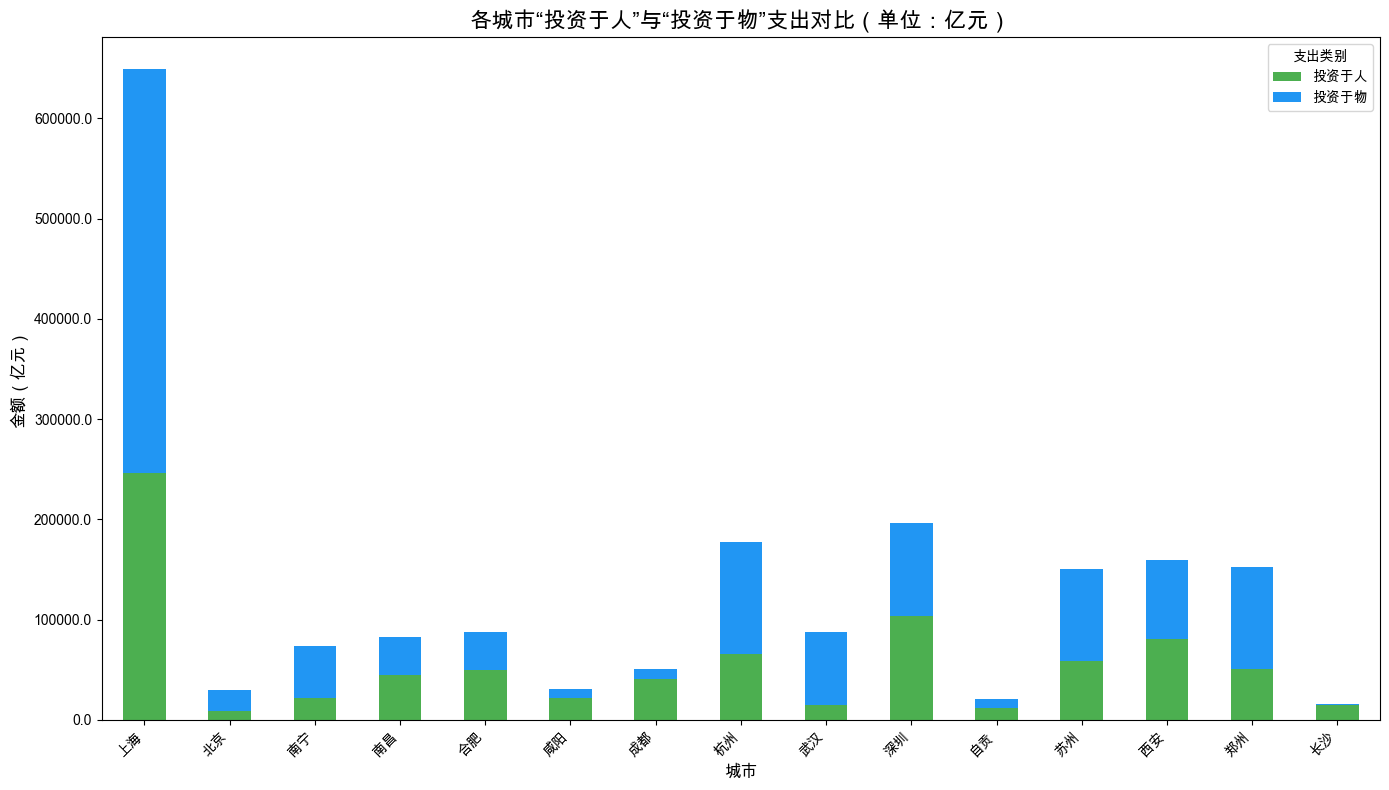

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = [
    'PingFang SC',
    'Heiti SC',
    'SimHei',
    'Arial Unicode MS'
]

# 读取数据
df = pd.read_csv("./output/investment_analysis.csv")

# 只保留有金额的记录（排除定性分析行）
df_amount = df.dropna(subset=['金额（万元）'])

# 将“万元”转换为“亿元”用于显示（1 亿元 = 10000 万元）
df_amount['金额（亿元）'] = df_amount['金额（万元）'] / 10000

# 按城市和类别汇总（单位：亿元）
city_totals = df_amount.groupby(['城市', '支出类别'])['金额（亿元）'].sum().unstack(fill_value=0)

# 绘图
ax = city_totals.plot(
    kind='bar',
    stacked=True,
    figsize=(14, 8),
    color=['#4CAF50', '#2196F3']  # human: green, physical: blue
)

# 设置标题和标签
plt.title('各城市“投资于人”与“投资于物”支出对比（单位：亿元）', fontsize=16)
plt.xlabel('城市', fontsize=12)
plt.ylabel('金额（亿元）', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['投资于人', '投资于物'], title='支出类别')

# 格式化 Y 轴：保留1位小数
from matplotlib.ticker import FuncFormatter
def billions(x, pos):
    return f'{x:.1f}'
ax.yaxis.set_major_formatter(FuncFormatter(billions))

plt.tight_layout()
plt.show()